Calculate the Bayes Factor for the sSFR to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_plot, Model_2_plot, uniform, jeffreys, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
#from functions_gauss import Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rc('font', size=14)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
sSFR = np.array(catalog_main['sSFR'])

## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

In [8]:
del catalog_main, catalog_north, data

# Fit the sSFR distributions with skewnormal distributions

Both one- and two-parent models

This is a bimodal distribution

In [9]:
sSFR_bins = np.arange(-13, -8, 0.1)

## 1-parent model

In [12]:
sSFR_fit_bounds1 = [[0.1, 5],    # s ........ Gaussian 1 to 2 scale factor
                    [500, 5000], # a ........ Gaussian a amplitude
                    [-12.5, -11.5], # mu_a ..... Gaussian a location
                    [0.01, 2],    # sigma_a .. Gaussian a scale
                    [-5, 5],    # skew_a ... Gaussian a skew
                    [500, 5000], # b ........ Gaussian b amplitude
                    [-11.5, -10.5],    # mu_b ..... Gaussian b location
                    [0.01, 2],    # sigma_b .. Gaussian b scale
                    [-5, 5],    # skew_b ... Gaussian b skew
                    [1000, 10000], # c ........ Gaussian b amplitude
                    [-10.5, -9],    # mu_c ..... Gaussian b location
                    [0.01, 1],    # sigma_c .. Gaussian b scale
                    [-5, 5]]    # skew_c ... Gaussian b skew

V2_sSFR_bestfit1 = Model_1_fit(sSFR_fit_bounds1, 
                               sSFR[wall_v2], 
                               sSFR[void_v2], 
                               sSFR_bins, 
                               3)

V2_sSFR_bestfit1

running minimizer...this might take a few minutes...


      fun: 673.9842776733897
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.40783439e-01, -3.88813097e-03, -1.15824141e-01,  1.84580813e+00,
       -6.76811855e-01, -2.39995452e-02,  2.08999591e+00, -6.27335336e-01,
        1.03000276e-02, -9.58844930e-02,  7.45185327e+00, -1.23478912e+01,
        1.64183121e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7252
      nit: 437
     njev: 518
   status: 0
  success: True
        x: array([ 2.43443649e+00,  2.57429162e+03, -1.20553199e+01,  4.18429971e-01,
        2.29382100e+00,  3.15010930e+03, -1.12613349e+01,  8.88278286e-01,
        1.18012807e+00,  3.47473427e+03, -9.72193571e+00,  3.89090348e-01,
       -1.13326619e+00])

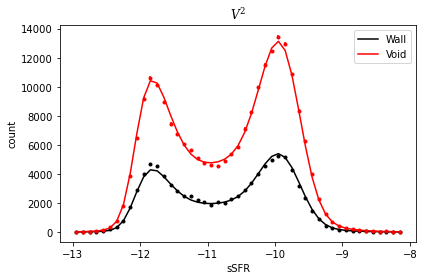

In [14]:
Model_1_plot(V2_sSFR_bestfit1.x, 
             sSFR[wall_v2], 
             sSFR[void_v2], 
             sSFR_bins, 
             3, 
             xlabel_text='sSFR', 
             title_text='$V^2$')

In [16]:
sSFR_fit_bounds1 = [[0.01, 1],    # s ........ Gaussian 1 to 2 scale factor
                    [1000, 10000], # a ........ Gaussian a amplitude
                    [-12.5, -11.5], # mu_a ..... Gaussian a location
                    [0.01, 1],    # sigma_a .. Gaussian a scale
                    [-5, 5],    # skew_a ... Gaussian a skew
                    [1000, 10000], # b ........ Gaussian b amplitude
                    [-11.5, -10.5],    # mu_b ..... Gaussian b location
                    [0.01, 1],    # sigma_b .. Gaussian b scale
                    [-5, 5],    # skew_b ... Gaussian b skew
                    [1000, 10000], # c ........ Gaussian b amplitude
                    [-10.5, -9],    # mu_c ..... Gaussian b location
                    [0.01, 1],    # sigma_c .. Gaussian b scale
                    [-5, 5]]    # skew_c ... Gaussian b skew

VF_sSFR_bestfit1 = Model_1_fit(sSFR_fit_bounds1, 
                               sSFR[wall_vf], 
                               sSFR[void_vf], 
                               sSFR_bins, 
                               3)

VF_sSFR_bestfit1

running minimizer...this might take a few minutes...


      fun: 3972.4462136650113
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([-24.125211  ,   0.08208276, -19.30138591,  -3.66017048,
         2.23126337,   0.04706685,   0.22250786,   1.50698724,
         9.16375035,   0.02450891, -23.31998792,  18.01904547,
         5.42622732])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10038
      nit: 574
     njev: 717
   status: 0
  success: True
        x: array([ 3.46004205e-01,  6.33360611e+03, -1.20575849e+01,  4.30101272e-01,
        2.38474688e+00,  7.40694419e+03, -1.12534479e+01,  8.89811698e-01,
        1.20400728e+00,  8.67346205e+03, -9.71404476e+00,  3.97671728e-01,
       -1.19520857e+00])

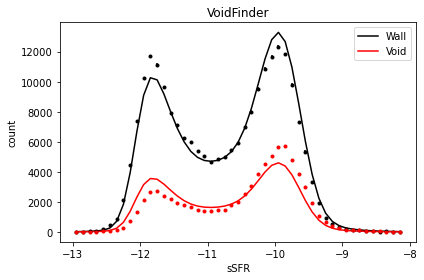

In [17]:
Model_1_plot(VF_sSFR_bestfit1.x, 
             sSFR[wall_vf], 
             sSFR[void_vf], 
             sSFR_bins, 
             3, 
             xlabel_text='sSFR', 
             title_text='VoidFinder')

### Nested sampling of Likelihood and Priors

#### V$^2$

In [43]:
def prior_xform1_bi_V2(u):
    '''
    Priors for the 9 parameters of bimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 5, u[0])
    
    a = jeffreys(1000, 10000, u[1])
    mu_a = uniform(-12.5, -11, u[2])
    sigma_a = uniform(0.01, 2, u[3])
    skew_a = uniform(0, 10, u[4])
    
    b = jeffreys(1000, 10000, u[5])
    mu_b = uniform(-11, -9, u[6])
    sigma_b = uniform(0.01, 2, u[7])
    skew_b = uniform(-5, 5, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b


def prior_xform1_tri_V2(u):
    '''
    Priors for the 13 parameters of trimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 5, u[0])
    
    a = jeffreys(1000, 10000, u[1])
    mu_a = uniform(-12.5, -11.5, u[2])
    sigma_a = uniform(0.1, 5, u[3])
    skew_a = uniform(0, 10, u[4])
    
    b = jeffreys(0, 5000, u[5])
    mu_b = uniform(-11.5, -11, u[6])
    sigma_b = uniform(0.1, 2, u[7])
    skew_b = uniform(0, 5, u[8])
    
    c = jeffreys(1000, 5000, u[9])
    mu_c = uniform(-10, -9, u[10])
    sigma_c = uniform(0.1, 1, u[11])
    skew_c = uniform(-5, 0, u[12])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b, c, mu_c, sigma_c, skew_c

In [44]:
Model_1_sampler(prior_xform1_tri_V2, 
                sSFR[wall_v2], 
                sSFR[void_v2], 
                sSFR_bins, 
                3, 
                '_sSFR_V2')

running the nested sampler... this might take from minutes to hours...


57409it [18:34, 51.50it/s, batch: 1 | bound: 21 | nc: 33 | ncall: 1782326 | eff(%):  3.221 | loglstar: -2671.606 < -2666.053 < -2668.577 | logz: -2713.413 +/-  0.214 | stop:  0.779]        


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_sSFR_V2'


In [45]:
temp_infile = open('dynesty_output/sampler_results_model1_sSFR_V2.pickle', 'rb')
dres1_V2_sSFR = pickle.load(temp_infile)
temp_infile.close()

In [23]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                   'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']
labels1_tri = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                    'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$', 
                    'c', r'$\mu_c$', r'$\sigma_c$', 'skew$_c$']

labels2_tri = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
               '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$',
               '$c_1$', r'$\mu_{1c}$', r'$\sigma_{1c}$', 'skew$_{1c}$',
               '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
               '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$', 
               '$c_2$', r'$\mu_{2c}$', r'$\sigma_{2c}$', 'skew$_{2c}$']

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:1315: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:2388: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(span[1])
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:2387: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(span[0])


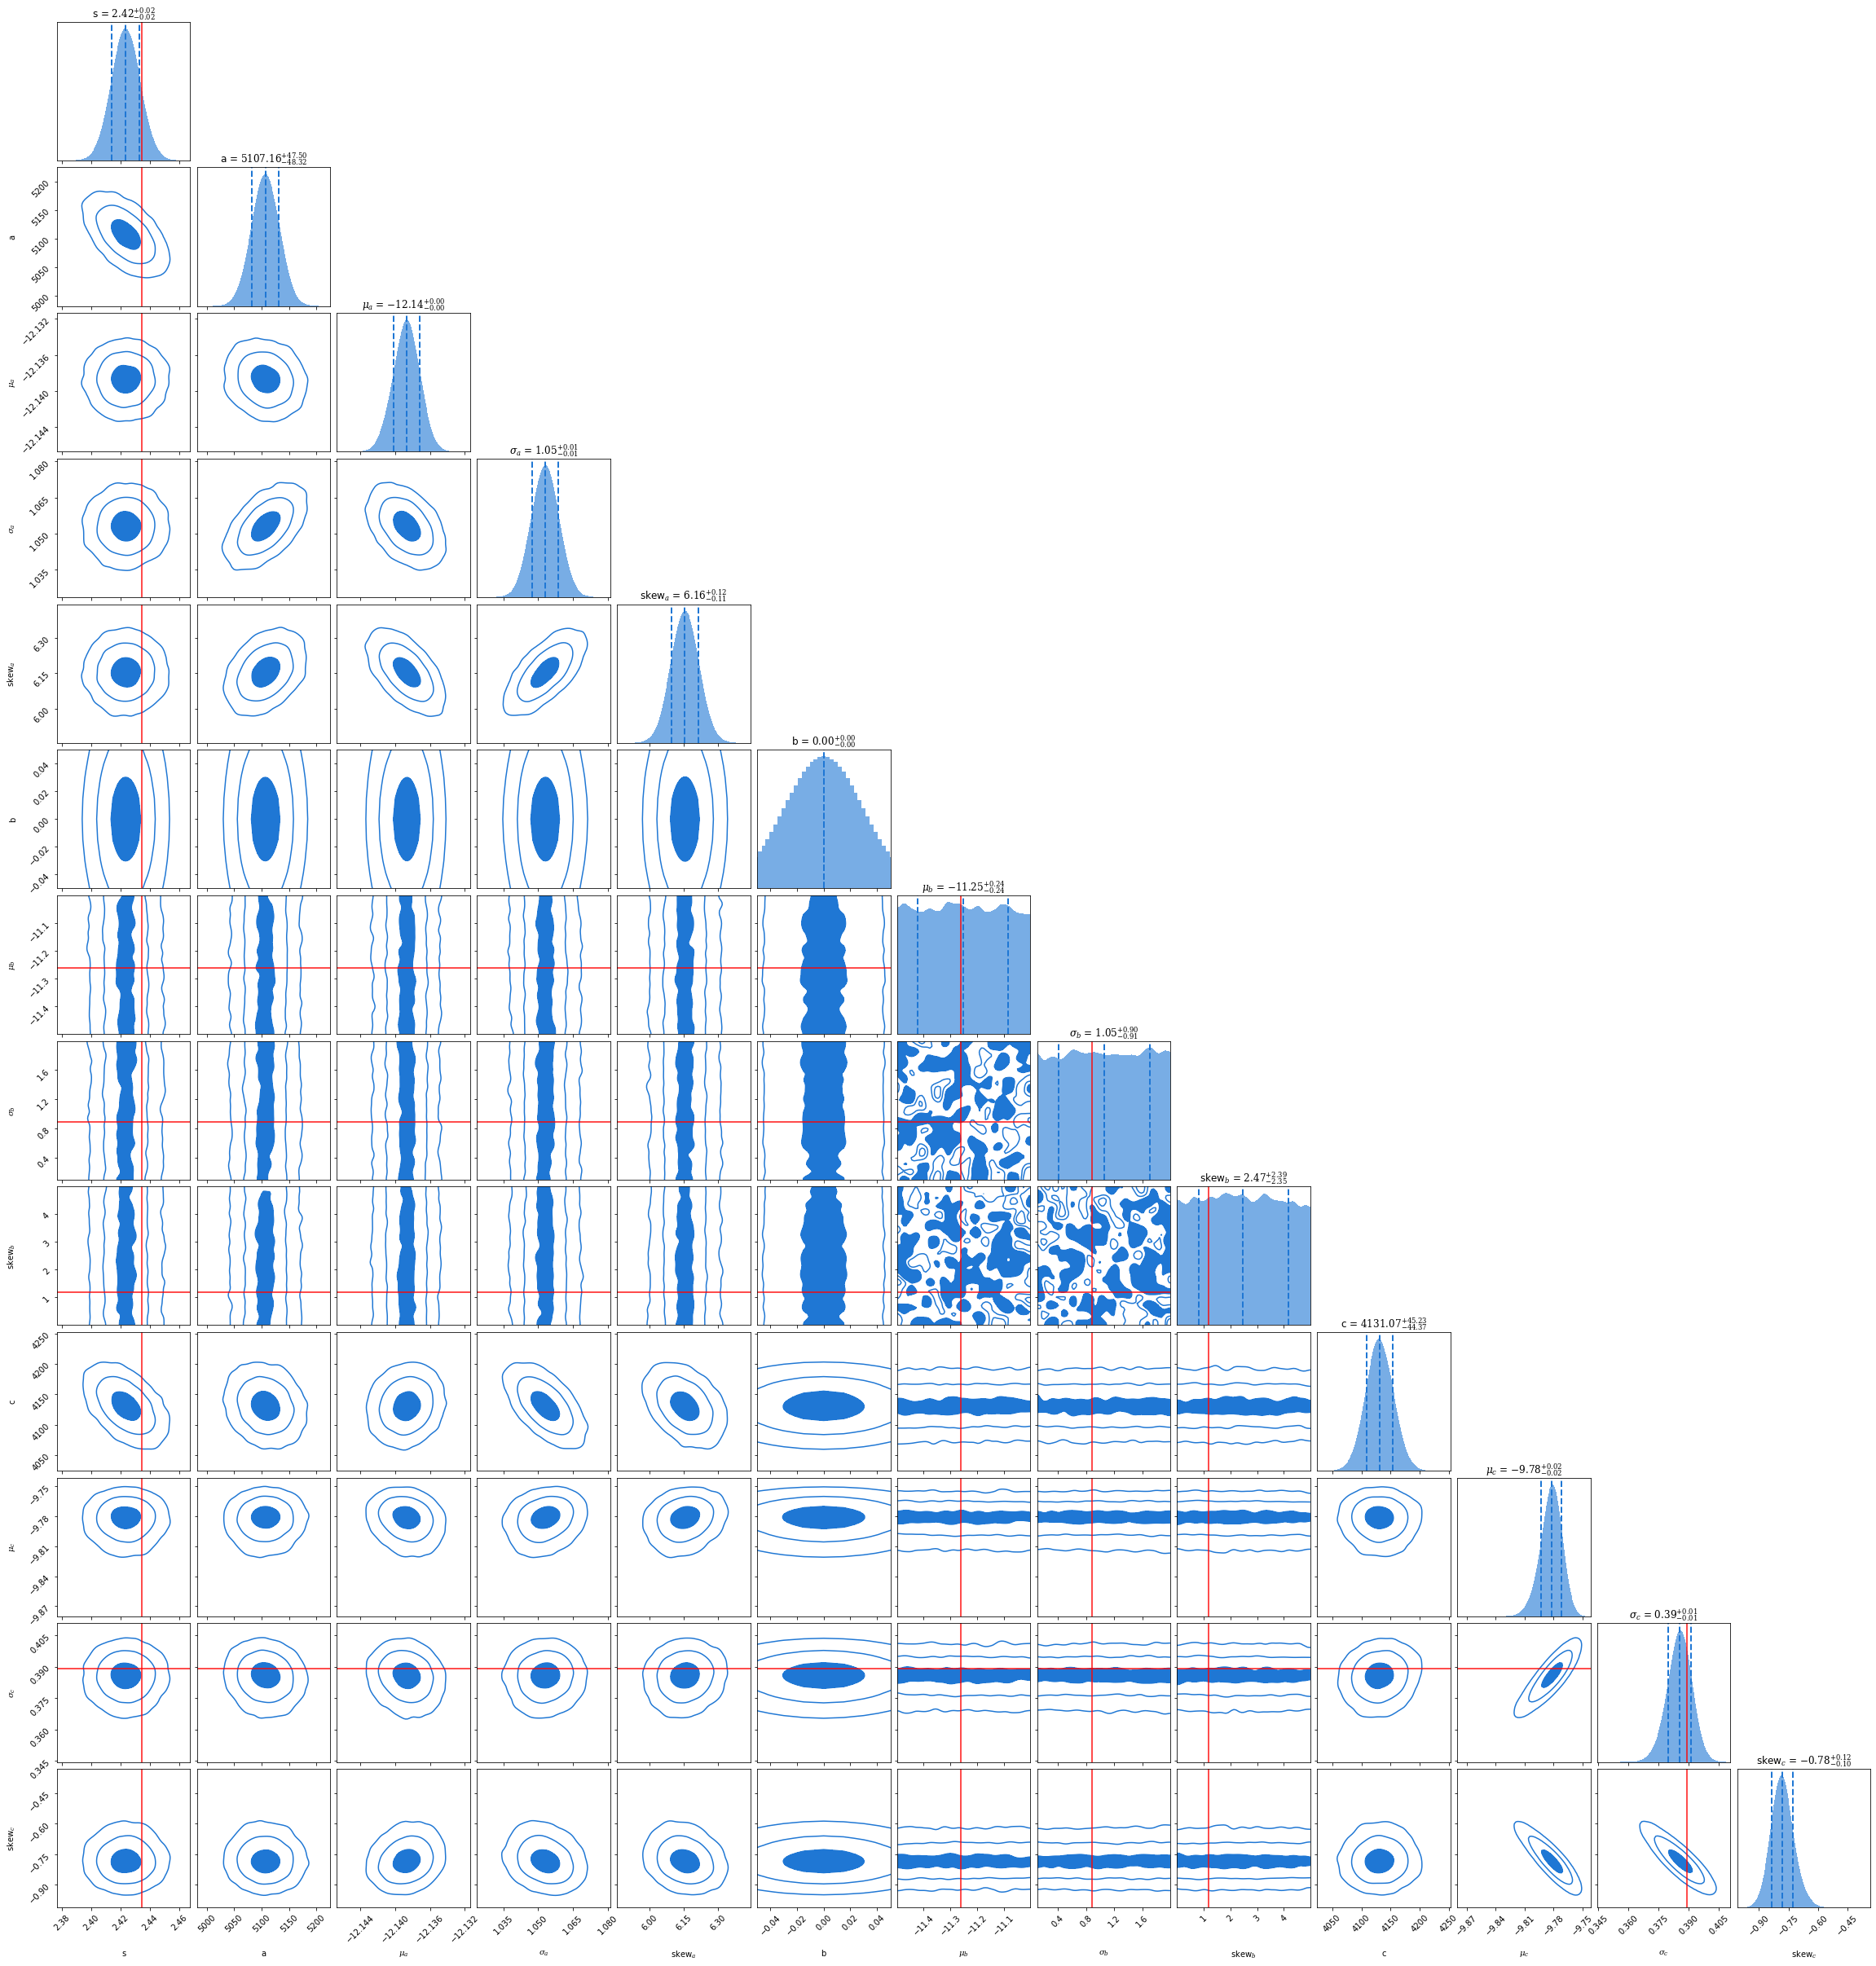

In [46]:
n_params = len(labels1_tri)

fig, axes = dyplot.cornerplot(dres1_V2_sSFR, smooth=0.03, 
                              labels=labels1_tri, 
                              truths=V2_sSFR_bestfit1.x, #[*V2_sSFR_bestfit1.x[:5], *V2_sSFR_bestfit1.x[9:]],
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:701: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([min(x), max(x)])
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:744: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])


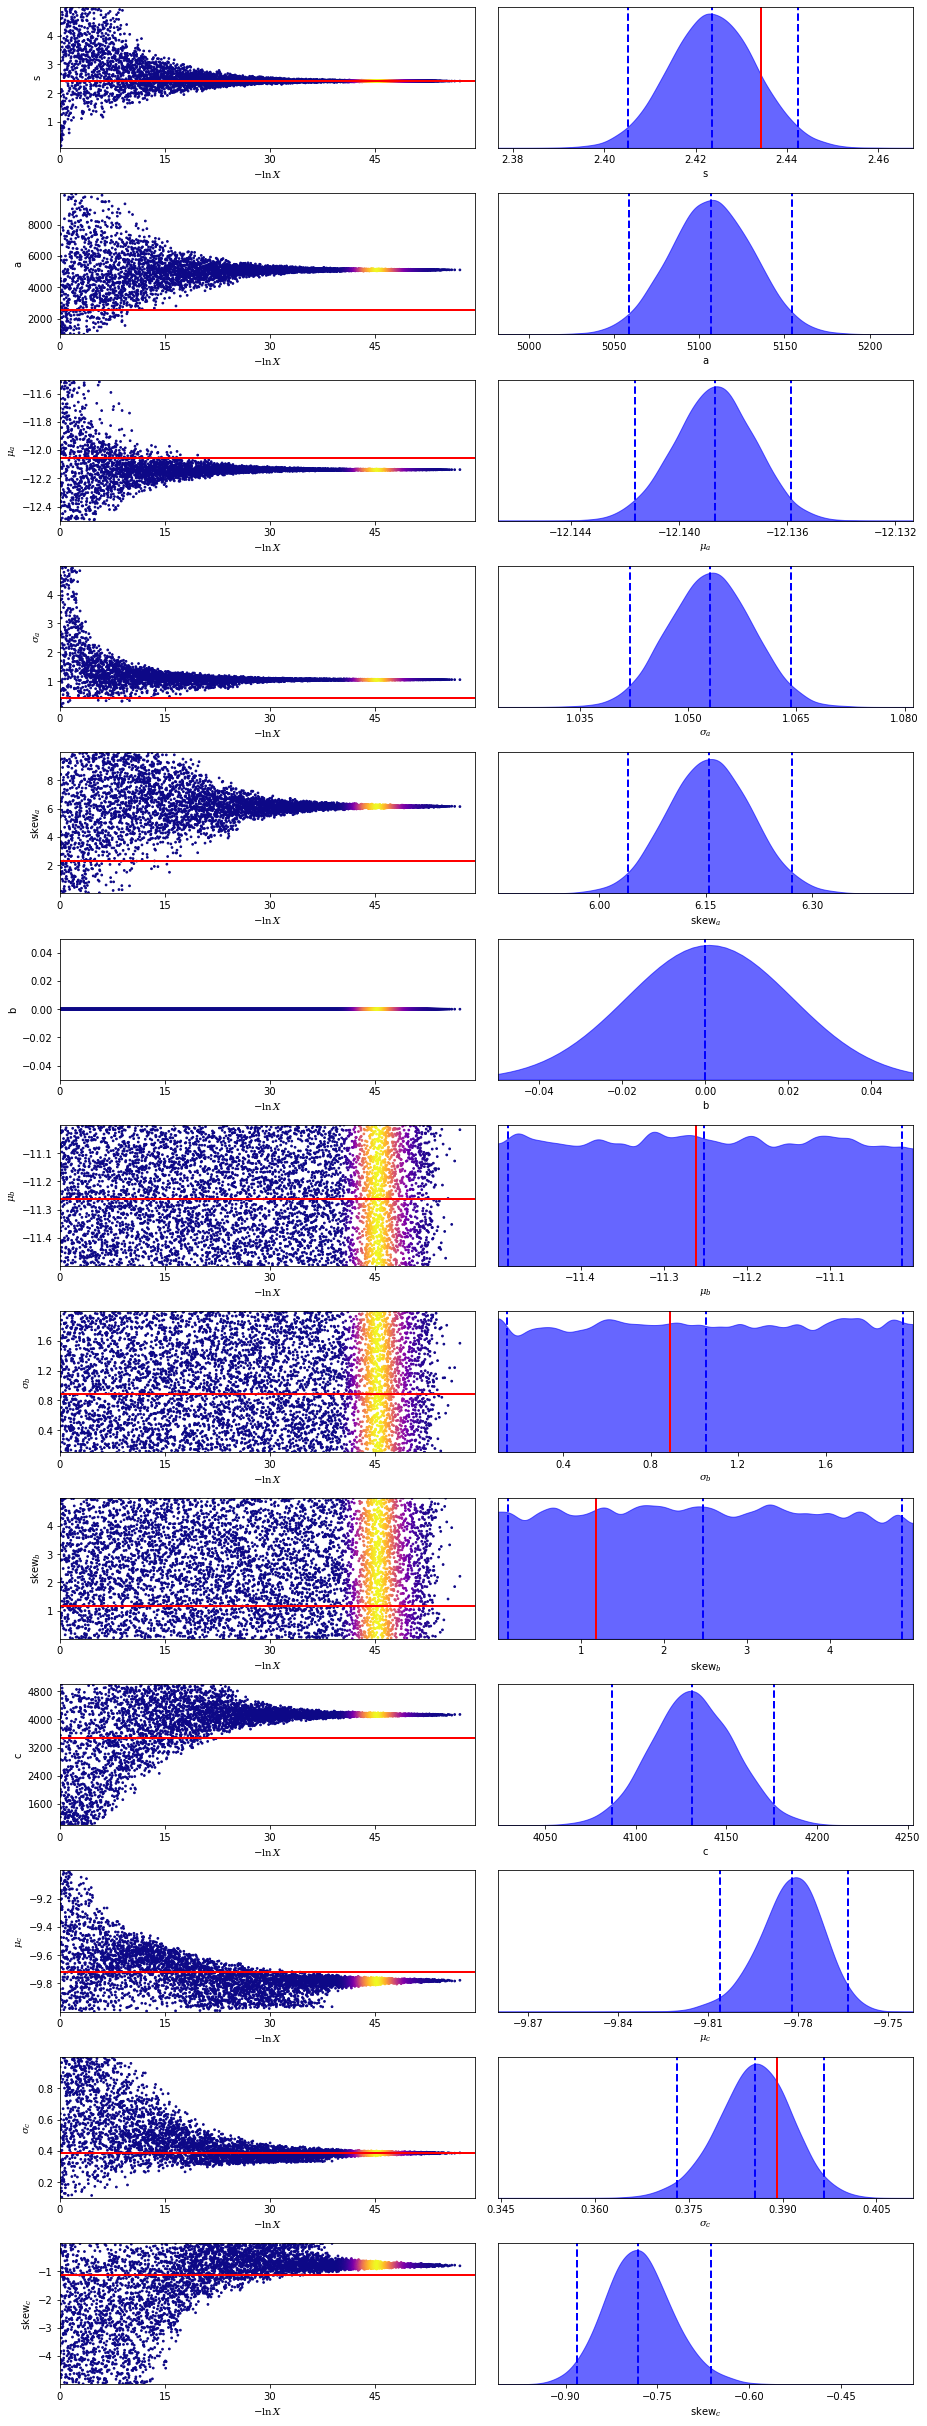

In [47]:
n_params = len(labels1_tri)

fig, axes = dyplot.traceplot(dres1_V2_sSFR, 
                             labels=labels1_tri, 
                             truths=V2_sSFR_bestfit1.x, #[*V2_sSFR_bestfit1.x[:5], *V2_sSFR_bestfit1.x[9:]],
                             fig=plt.subplots(n_params, 2, figsize=(n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout()

In [48]:
lnzM1_V2_sSFR = dres1_V2_sSFR.logz[-1]
lnzM1_V2_sSFR

-2713.3803549204963

In [49]:
V2_sSFR_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_V2_sSFR.samples, 
                                                 np.exp(dres1_V2_sSFR.logwt - lnzM1_V2_sSFR))

V2_sSFR_bestfit1_dynesty

array([ 2.42374946e+00,  5.10702576e+03, -1.21387004e+01,  1.05307248e+00,
        6.15530074e+00,  0.00000000e+00, -1.12512074e+01,  1.05709647e+00,
        2.48486661e+00,  4.13137390e+03, -9.78261306e+00,  3.85467544e-01,
       -7.79957541e-01])

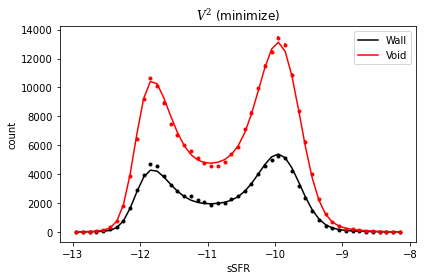

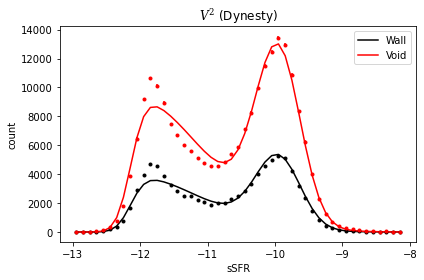

In [50]:
Model_1_plot(V2_sSFR_bestfit1.x, 
             sSFR[wall_v2], 
             sSFR[void_v2], 
             sSFR_bins, 
             3, 
             xlabel_text='sSFR', 
             title_text='$V^2$ (minimize)')

Model_1_plot(V2_sSFR_bestfit1_dynesty, 
             sSFR[wall_v2], 
             sSFR[void_v2], 
             sSFR_bins, 
             3, 
             xlabel_text='sSFR', 
             title_text='$V^2$ (Dynesty)')

##### Calculate $-\ln (\mathcal{L})$ for fit

In [51]:
from functions import nlogLjoint1_skew, bin_data

x, n1, n2, dn1, dn2 = bin_data(sSFR[wall_v2], sSFR[void_v2], sSFR_bins)

nlogLjoint1_skew(V2_sSFR_bestfit1_dynesty, n1, n2, x, 3)

2665.3873456105644

#### VoidFinder

In [113]:
def prior_xform1_bi_VF(u):
    '''
    Priors for the 9 parameters of bimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.01, 1, u[0])
    
    a = jeffreys(2000, 8000, u[1])
    mu_a = uniform(-2, -0.5, u[2])
    sigma_a = uniform(0.01, 1, u[3])
    skew_a = uniform(-5, 0, u[4])
    
    b = jeffreys(10000, 20000, u[5])
    mu_b = uniform(-0.5, 1, u[6])
    sigma_b = uniform(0.1, 1.5, u[7])
    skew_b = uniform(-5, 0, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b


def prior_xform1_tri_VF(u):
    '''
    Priors for the 13 parameters of trimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.01, 1, u[0])
    
    a = jeffreys(1000, 20000, u[1])
    mu_a = uniform(-12.5, -11.5, u[2])
    sigma_a = uniform(0.01, 5, u[3])
    skew_a = uniform(0, 10, u[4])
    
    b = jeffreys(0, 10000, u[5])
    mu_b = uniform(-11.5, -10.5, u[6])
    sigma_b = uniform(0.1, 2, u[7])
    skew_b = uniform(-2.5, 2.5, u[8])

    c = jeffreys(1000, 15000, u[9])
    mu_c = uniform(-10.5, -9, u[10])
    sigma_c = uniform(0.1, 1, u[11])
    skew_c = uniform(-5, 5, u[12])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b, c, mu_c, sigma_c, skew_c

In [114]:
Model_1_sampler(prior_xform1_tri_VF, 
                sSFR[wall_vf], 
                sSFR[void_vf], 
                sSFR_bins, 
                3, 
                '_sSFR_VoidFinder')

running the nested sampler... this might take from minutes to hours...


13949it [03:10, 76.97it/s, batch: 0 | bound: 181 | nc: 25 | ncall: 323645 | eff(%):  4.303 | loglstar:   -inf < -5953.818 <    inf | logz: -5985.482 +/-  0.351 | dlogz: 149.452 >  0.010]   /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
14167it [03:14, 75.03it/s, batch: 0 | bound: 185 | nc: 25 | ncall: 330651 | eff(%):  4.278 | loglstar:   -inf < -5931.059 <    inf | logz: -5963.371 +/-  0.353 | dlogz: 126.926 >  0.010]/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
14328it [03:17, 74.28it/s, batch: 0 | bound: 188 | nc: 25 | ncall: 335848 | eff(%):  4.260 | loglstar: 

sampler output saved as pickle file 'dynesty_output/sampler_results_model1_sSFR_VoidFinder'


In [115]:
temp_infile = open('dynesty_output/sampler_results_model1_sSFR_VoidFinder.pickle', 'rb')
dres1_VF_sSFR = pickle.load(temp_infile)
temp_infile.close()

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:1199: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:2238: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(span[1])
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:2237: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(span[0])


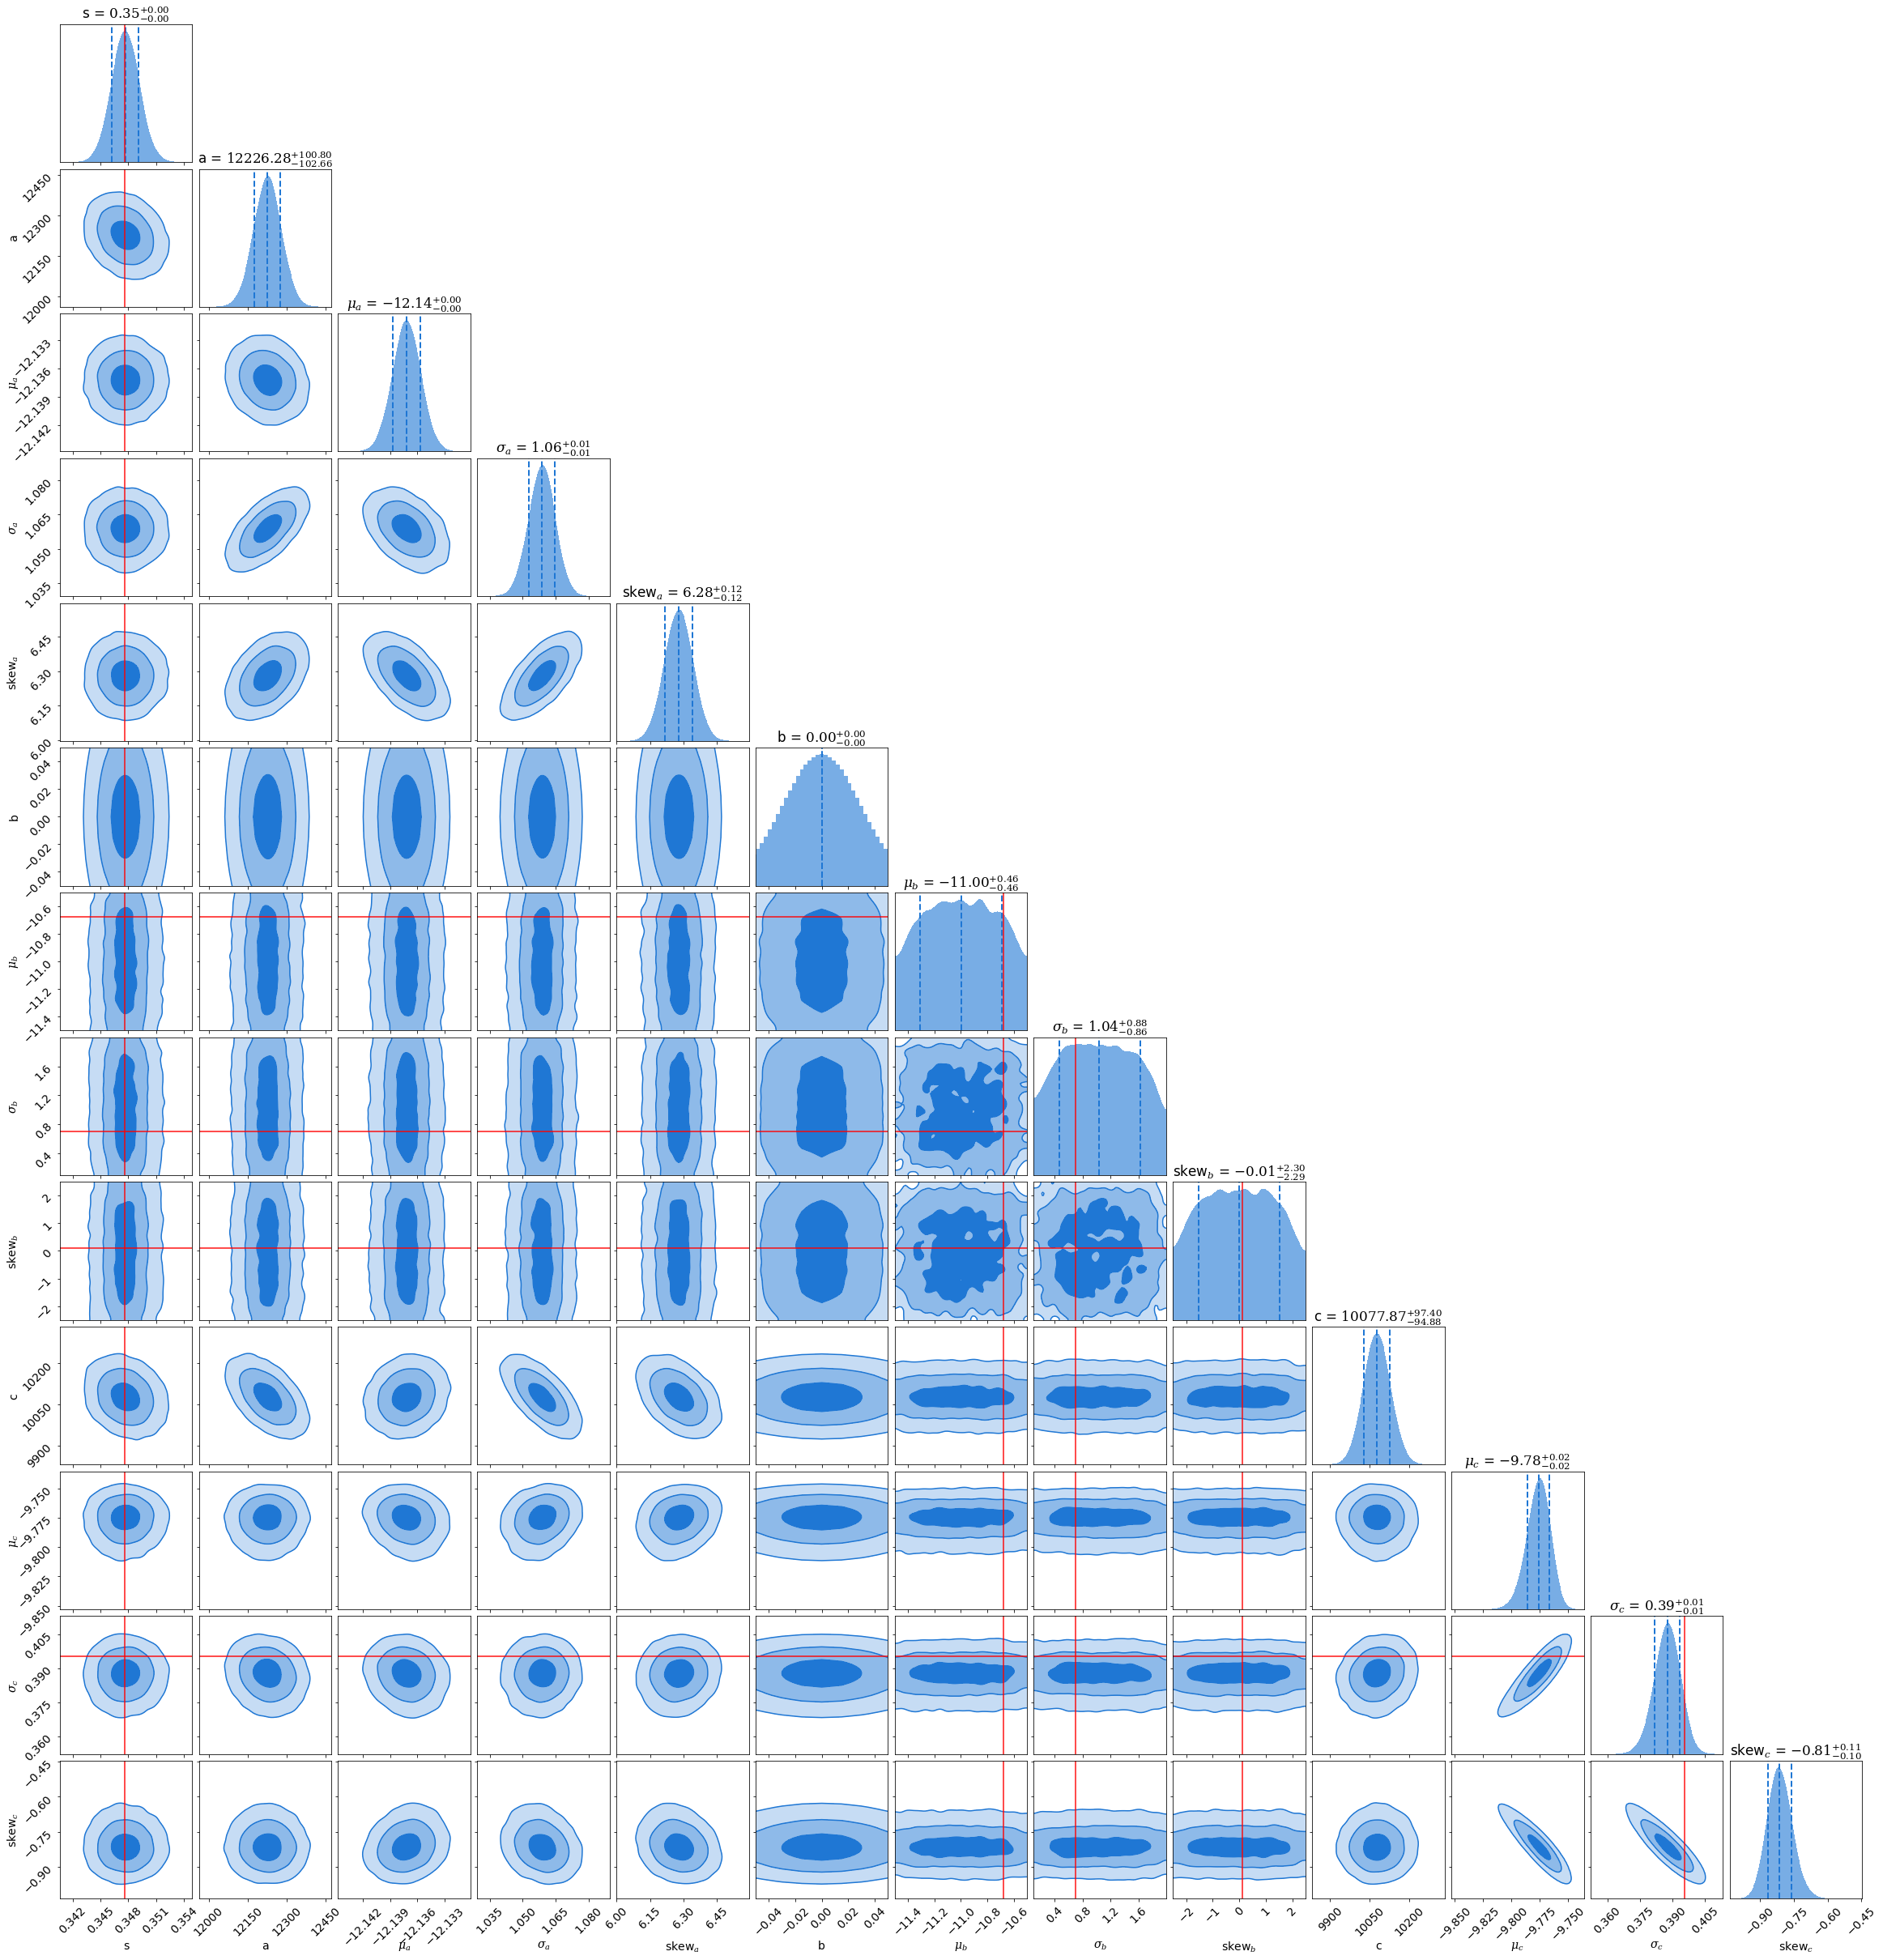

In [116]:
n_params = len(labels1_tri)

fig, axes = dyplot.cornerplot(dres1_VF_sSFR, smooth=0.03, 
                              labels=labels1_tri, 
                              truths=VF_sSFR_bestfit1.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:602: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([min(x), max(x)])
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:644: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])


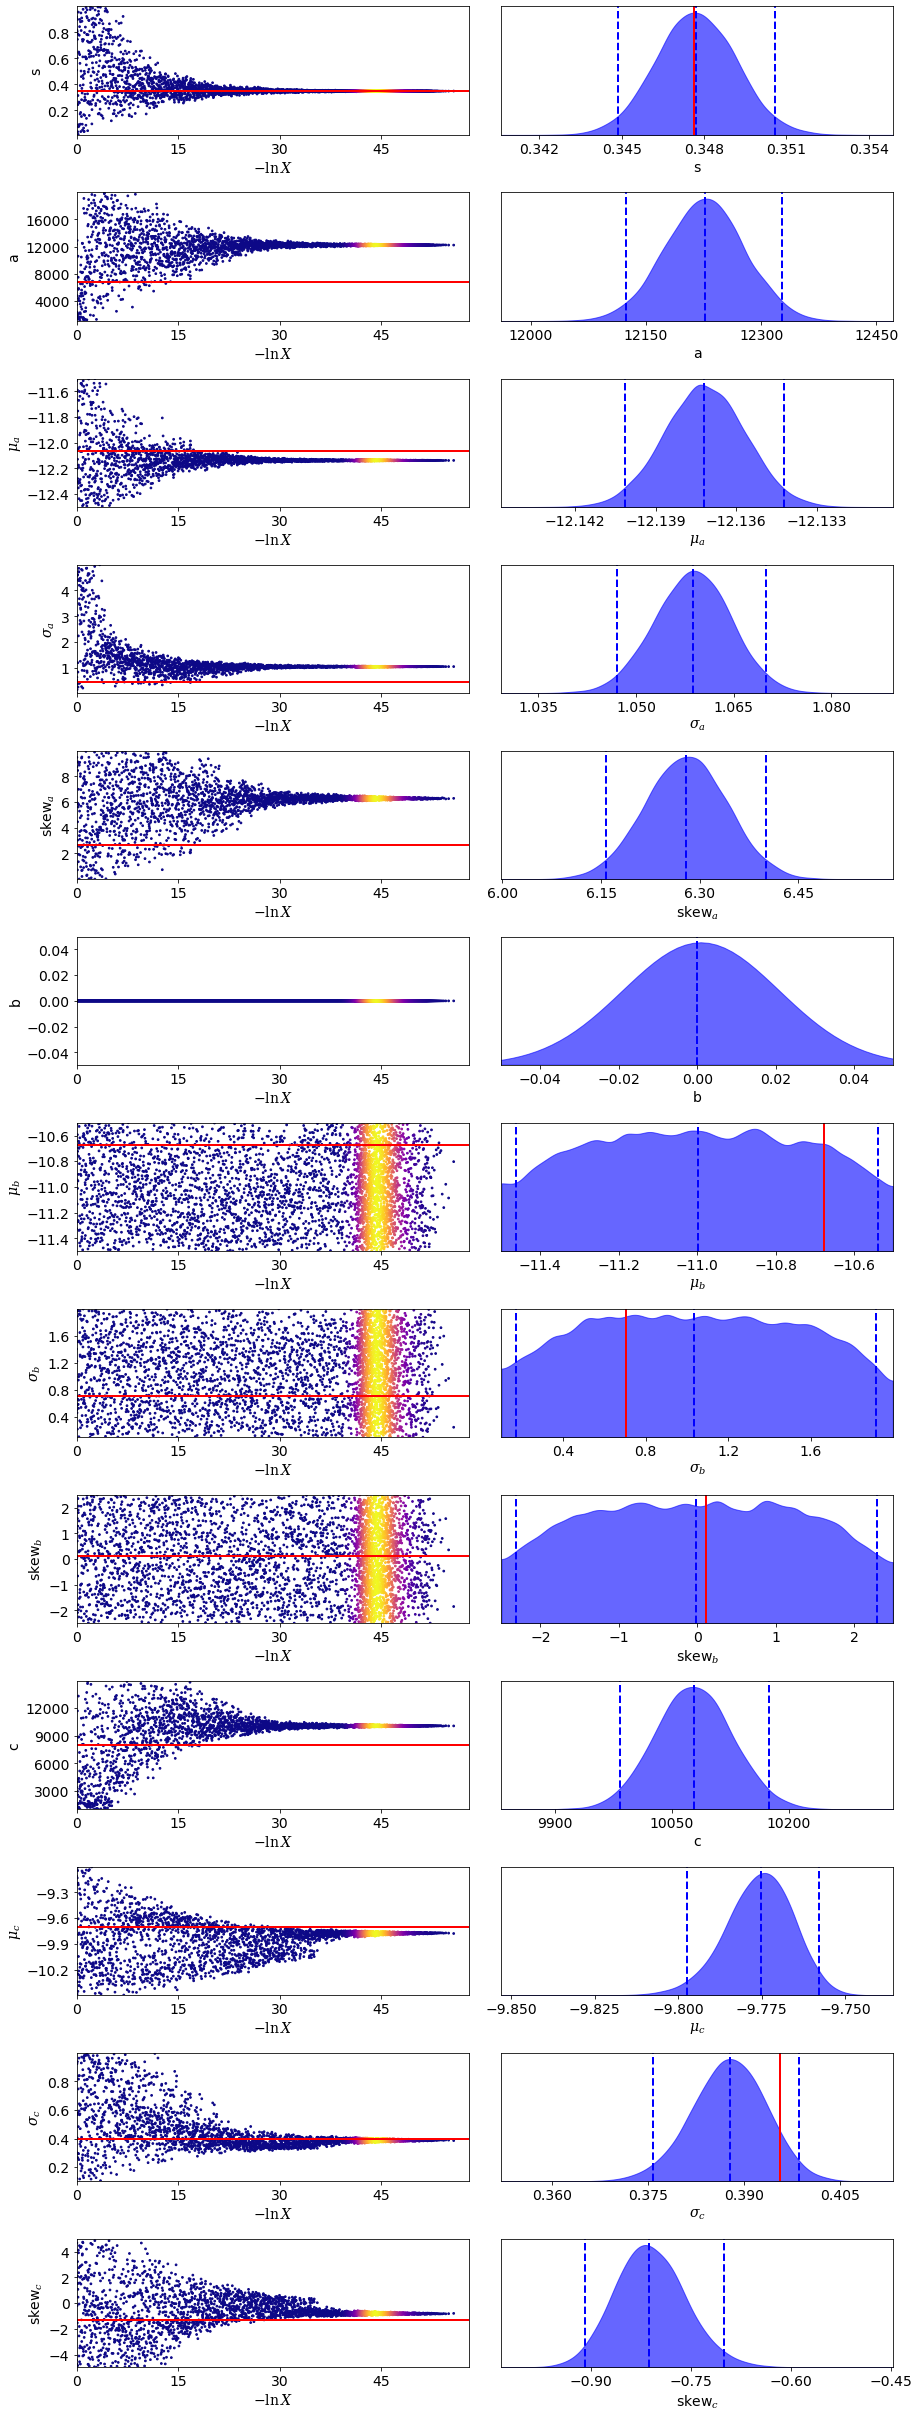

In [117]:
n_params = len(labels1_tri)

fig, axes = dyplot.traceplot(dres1_VF_sSFR, 
                             labels=labels1_tri, 
                             truths=VF_sSFR_bestfit1.x, #[*V2_sSFR_bestfit1.x[:5], *V2_sSFR_bestfit1.x[9:]],
                             fig=plt.subplots(n_params, 2, figsize=(n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout()

In [118]:
lnzM1_VF_sSFR = dres1_VF_sSFR.logz[-1]
lnzM1_VF_sSFR

-5806.545356230049

In [119]:
VF_sSFR_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_VF_sSFR.samples, 
                                                 np.exp(dres1_VF_sSFR.logwt - lnzM1_VF_sSFR))

VF_sSFR_bestfit1_dynesty

array([ 3.47710238e-01,  1.22260677e+04, -1.21371801e+01,  1.05866010e+00,
        6.27910418e+00,  0.00000000e+00, -1.09983941e+01,  1.04025756e+00,
       -1.02668081e-02,  1.00780421e+04, -9.77588989e+00,  3.87568125e-01,
       -8.11173550e-01])

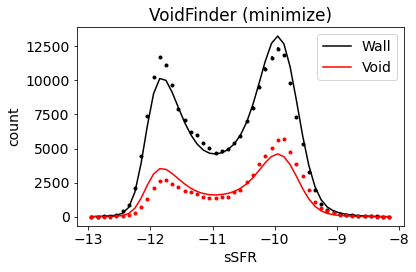

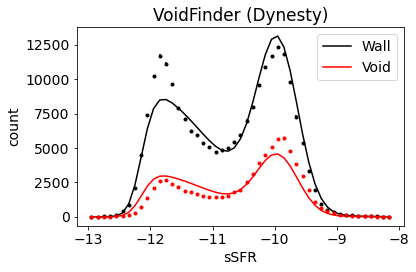

In [120]:
Model_1_plot(VF_sSFR_bestfit1.x, 
             sSFR[wall_vf], 
             sSFR[void_vf], 
             sSFR_bins, 
             3, 
             xlabel_text='sSFR', 
             title_text='VoidFinder (minimize)')

Model_1_plot(VF_sSFR_bestfit1_dynesty, 
             sSFR[wall_vf], 
             sSFR[void_vf], 
             sSFR_bins, 
             3, 
             xlabel_text='sSFR', 
             title_text='VoidFinder (Dynesty)')

### 2-parent model

In [33]:
# 1 = wall, 2 = void

SFR_fit_bounds2 = [[500, 5000],   # a1 ........ Gaussian A1 amplitude
                   [-2, -0.5],    # mu_a1 ..... Gaussian A1 location
                   [0.01, 2],     # sigma_a1 .. Gaussian A1 scale
                   [-5, 5],       # skew_a1 ... Gaussian A1 skew
                   [500, 10000],  # b1 ........ Gaussian B1 amplitude
                   [-0.5, 1],     # mu_b1 ..... Gaussian B1 location
                   [0.1, 3],      # sigma_b1 .. Gaussian B1 scale
                   [-10, 0],      # skew_b1 ... Gaussian B1 skew
                   [500, 10000],  # a2 ........ Gaussian A2 amplitude
                   [-2, -0.5],    # mu_a2 ..... Gaussian A2 location
                   [0.01, 2],     # sigma_a2 .. Gaussian A2 scale
                   [-5, 5],       # skew_a2 ... Gaussian A2 skew
                   [1000, 20000], # b2 ........ Gaussian B2 amplitude
                   [-0.5, 1],     # mu_b2 ..... Gaussian B2 location
                   [0.1, 3],      # sigma_b2 .. Gaussian B2 scale
                   [-10, 0]]      # skew_b2 ... Gaussian B2 skew

V2_SFR_bestfit2 = Model_2_fit(SFR_fit_bounds2, 
                              SFR[wall_v2], 
                              SFR[void_v2], 
                              SFR_bins, 
                              2)

running minimizer...this might take a few minutes...


In [34]:
V2_SFR_bestfit2

      fun: 1064.5074440937958
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.23371987,  0.23517259,  0.23158009, -0.78835001,  0.03817644,
       -0.11111751,  0.87186436,  0.42359716,  0.1897226 , -0.49183199,
       -1.44430032,  0.23828761,  0.20523372,  0.5863285 ,  0.54731117,
        0.05777565])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7990
      nit: 392
     njev: 470
   status: 0
  success: True
        x: array([ 1.90825889e+03, -8.49186510e-01,  3.19247502e-01, -1.49705532e+00,
        7.30793531e+03,  5.66978527e-01,  1.00400859e+00, -3.08300023e+00,
        7.86867153e+03, -7.37007015e-01,  4.65176303e-01, -2.03304390e+00,
        1.49547375e+04,  3.86310843e-01,  6.32204885e-01, -1.38115178e+00])

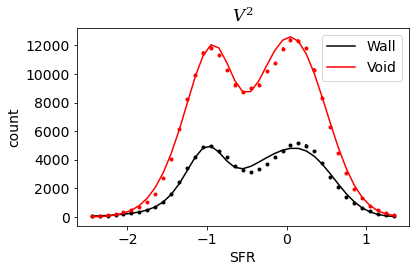

In [36]:
Model_2_plot(V2_SFR_bestfit2.x, 
             SFR[wall_v2], 
             SFR[void_v2], 
             SFR_bins, 
             2, 
             xlabel_text='SFR', 
             title_text='$V^2$')

In [40]:
# 1 = wall, 2 = void

SFR_fit_bounds2 = [[500, 20000], # a1 ........ Gaussian A1 amplitude
                   [-2, -0.5],     # mu_a1 ..... Gaussian A1 location
                   [0.01, 3],   # sigma_a1 .. Gaussian A1 scale
                   [-5, 5],      # skew_a1 ... Gaussian A1 skew
                   [500, 20000], # b1 ........ Gaussian B1 amplitude
                   [-0.5, 1],   # mu_b1 ..... Gaussian B1 location
                   [0.01, 3],   # sigma_b1 .. Gaussian B1 scale
                   [-5, 5],      # skew_b1 ... Gaussian B1 skew
                   [100, 5000], # a2 ........ Gaussian A2 amplitude
                   [-2, -0.5],     # mu_a2 ..... Gaussian A2 location
                   [0.01, 3],   # sigma_a2 .. Gaussian A2 scale
                   [-5, 5],       # skew_a2 ... Gaussian A2 skew
                   [100, 5000],  # b2 ........ Gaussian B2 amplitude
                   [-0.5, 1],   # mu_b2 ..... Gaussian B2 location
                   [0.01, 3],   # sigma_b2 .. Gaussian B2 scale
                   [-5, 5]]      # skew_b2 ... Gaussian B2 skew

VF_SFR_bestfit2 = Model_2_fit(SFR_fit_bounds2, 
                              SFR[wall_vf], 
                              SFR[void_vf], 
                              SFR_bins, 
                              2)

VF_SFR_bestfit2

running minimizer...this might take a few minutes...


      fun: 932.7420397516998
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00085266,  0.20323796, -0.15144224,  0.45558864, -0.02882866,
       -0.67767587,  0.18623041, -0.12729515,  0.03196908,  0.00775344,
       -0.22137101, -0.00104592, -0.00188722,  0.37912287,  0.63938614,
        0.24469955])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11900
      nit: 591
     njev: 700
   status: 0
  success: True
        x: array([ 6.44702349e+03, -7.98982558e-01,  3.90908170e-01, -1.74386613e+00,
        1.57875805e+04,  5.10438425e-01,  8.67917714e-01, -2.44472492e+00,
        4.27342954e+03, -1.18412075e+00,  7.11354702e-01,  1.49625946e+00,
        3.48128144e+03, -1.00370979e-01,  4.58830157e-01,  1.57448703e+00])

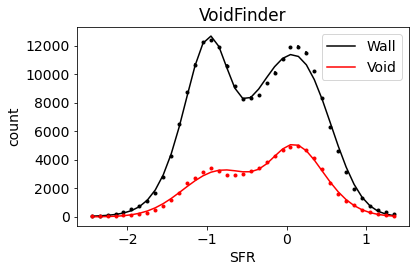

In [41]:
Model_2_plot(VF_SFR_bestfit2.x, 
             SFR[wall_vf], 
             SFR[void_vf], 
             SFR_bins, 
             2, 
             xlabel_text='SFR', 
             title_text='VoidFinder')

#### Nested sampling of Likelihood and Priors

##### V$^2$

In [68]:
def prior_xform2_bi_V2(u):
    '''
    Priors for the 16 parameters of bimodal M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(1000, 10000, u[0])
    mu_a1 = uniform(-2, -0.5, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(-5, 5, u[3])

    b1 = jeffreys(1000, 10000, u[4])
    mu_b1 = uniform(-0.5, 1, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 5, u[7])
    
    a2 = jeffreys(1000, 15000, u[8])
    mu_a2 = uniform(-2, -0.5, u[9])
    sigma_a2 = uniform(0.01, 2, u[10])
    skew_a2 = uniform(-5, 5, u[11])

    b2 = jeffreys(5000, 20000, u[12])
    mu_b2 = uniform(-0.5, 1, u[13])
    sigma_b2 = uniform(0.01, 2, u[14])
    skew_b2 = uniform(-5, 5, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [69]:
Model_2_sampler(prior_xform2_bi_V2, 
                SFR[wall_v2], 
                SFR[void_v2], 
                SFR_bins, 
                2, 
                '_SFR_V2')

running the nested sampler... this might take from minutes to hours...


1810it [00:11, 49.73it/s, batch: 0 | bound: 0 | nc: 66 | ncall: 17553 | eff(%): 10.026 | loglstar:   -inf < -84382.410 <    inf | logz: -84392.934 +/-  0.205 | dlogz: 61003.617 >  0.010]   /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
11937it [03:27, 57.94it/s, batch: 0 | bound: 149 | nc: 25 | ncall: 272253 | eff(%):  4.376 | loglstar:   -inf < -4506.744 <    inf | logz: -4535.797 +/-  0.337 | dlogz: 1896.541 >  0.010] /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
14038it [04:06, 58.38it/s, batch: 0 | bound: 181 | nc: 25 | ncall: 329747 | eff(%):  4.251 | loglstar:   -inf

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_SFR_V2'


In [70]:
temp_infile = open('dynesty_output/sampler_results_model2_SFR_V2.pickle', 'rb')
dres2_V2_SFR = pickle.load(temp_infile)
temp_infile.close()

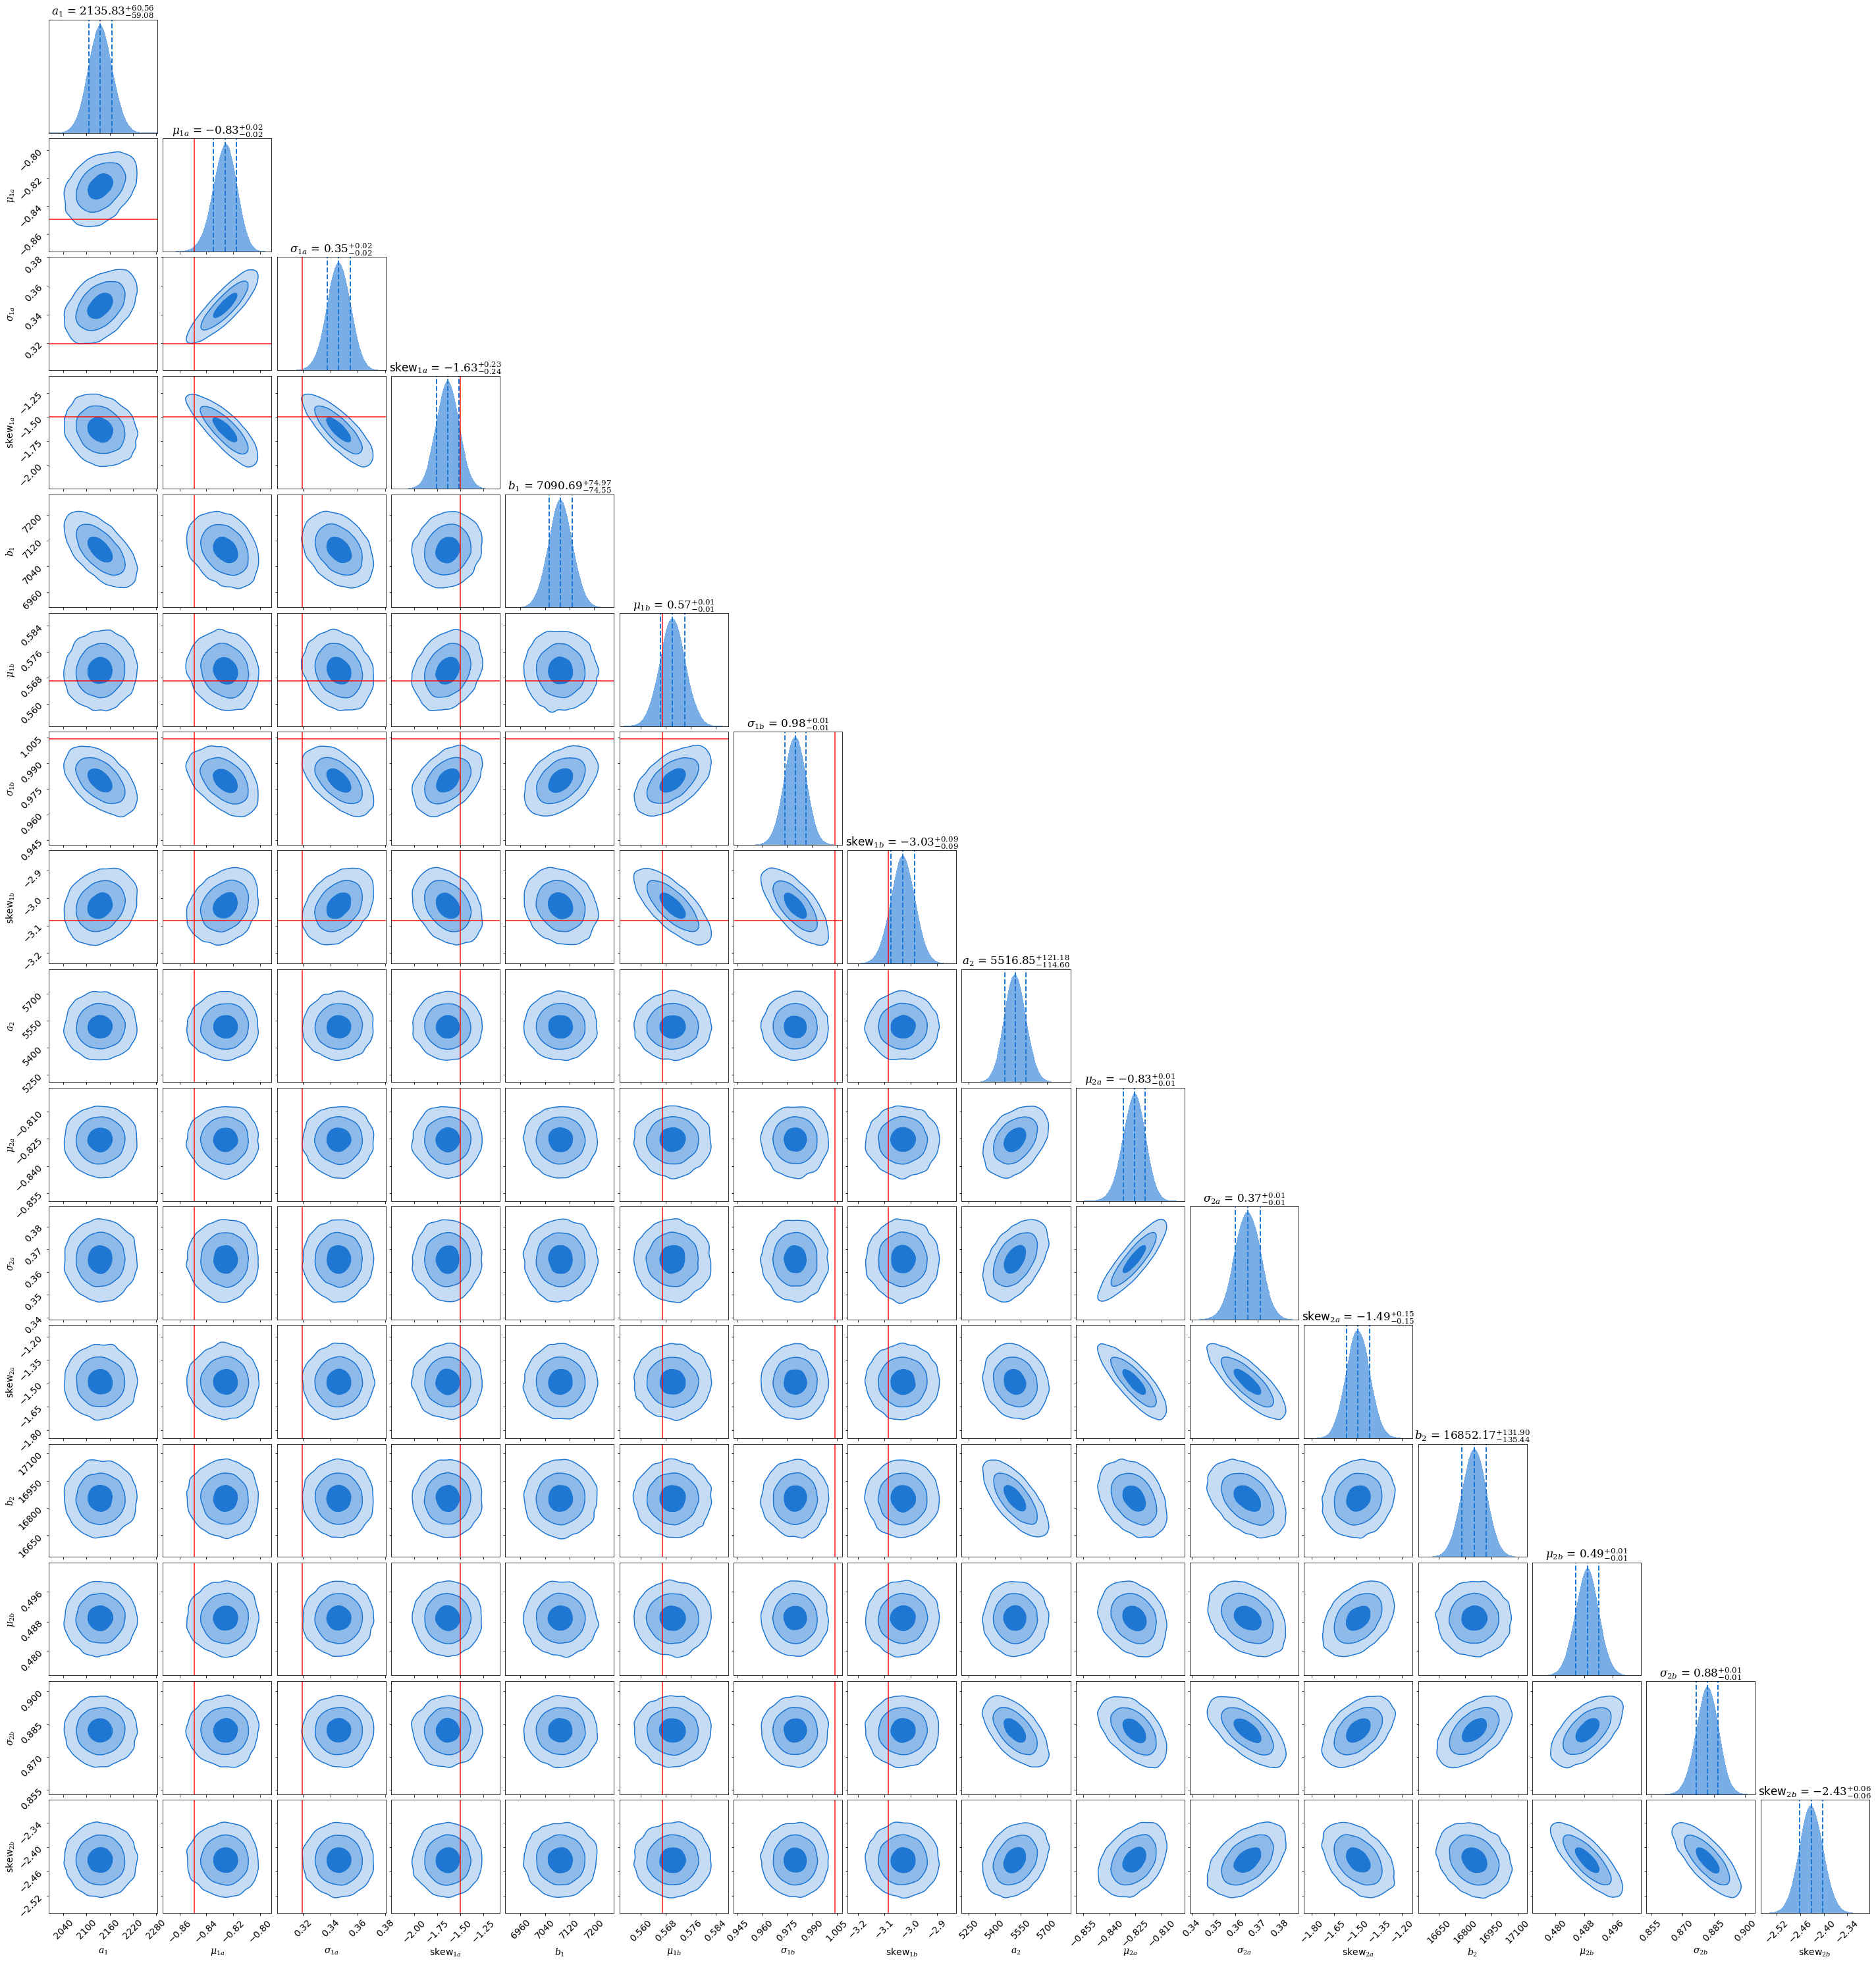

In [71]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_V2_SFR, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=V2_SFR_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

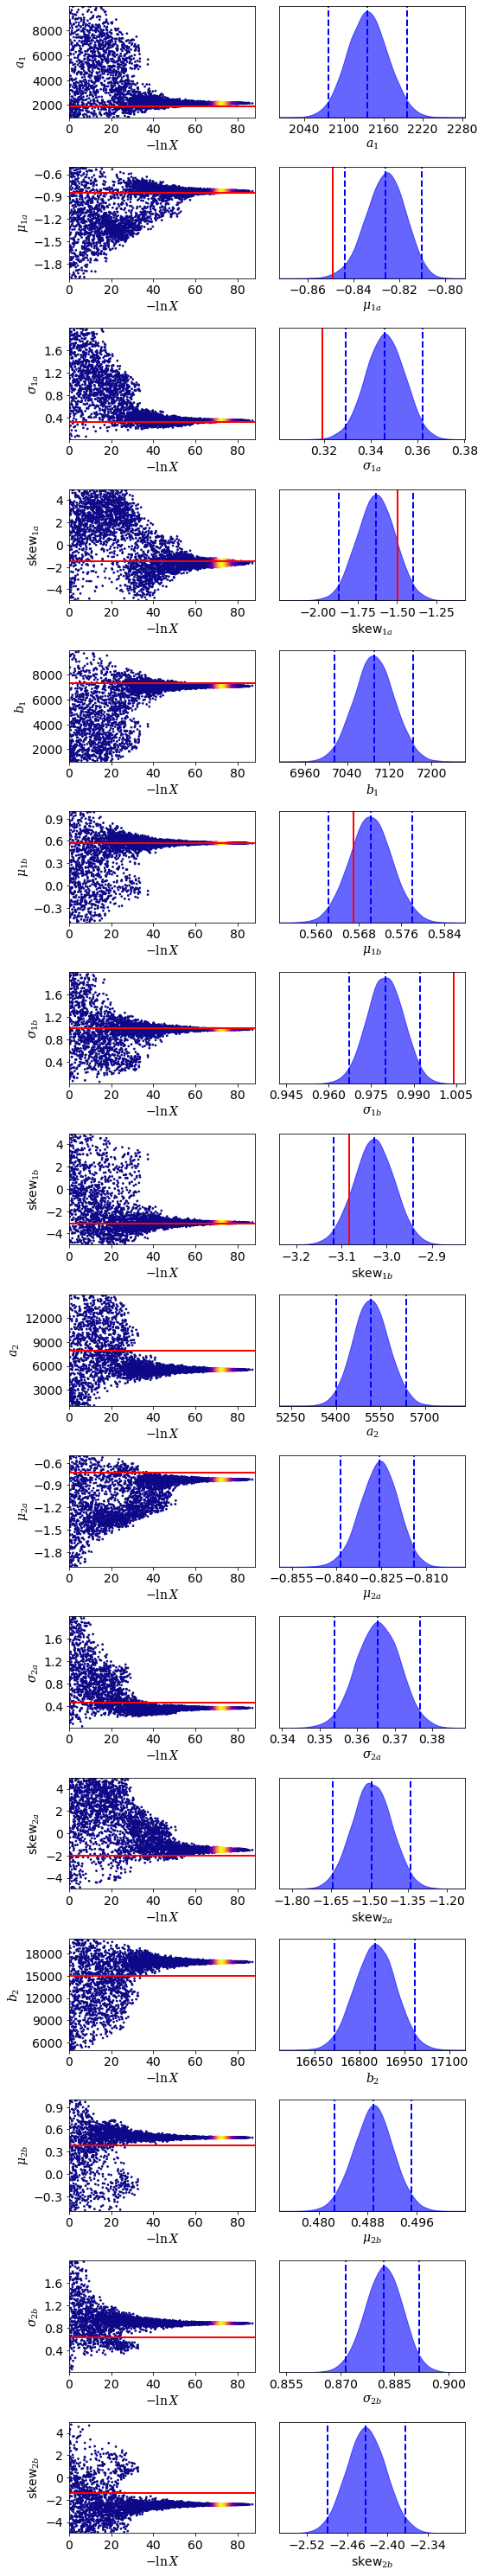

In [72]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_V2_SFR, 
                             labels=labels2_bi, 
                             truths=V2_SFR_bestfit2.x,
                             fig=plt.subplots(n_params, 2, figsize=(0.5*n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [73]:
lnzM2_V2_SFR = dres2_V2_SFR.logz[-1]
lnzM2_V2_SFR

-939.0909736895719

In [74]:
V2_SFR_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_V2_SFR.samples, 
                                                np.exp(dres2_V2_SFR.logwt - lnzM2_V2_SFR))

V2_SFR_bestfit2_dynesty

array([ 2.13604505e+03, -8.26210175e-01,  3.46029112e-01, -1.63438402e+00,
        7.09091617e+03,  5.70200633e-01,  9.79883485e-01, -3.02863336e+00,
        5.51773466e+03, -8.25832250e-01,  3.65523306e-01, -1.49110446e+00,
        1.68516012e+04,  4.88888751e-01,  8.81936514e-01, -2.43172457e+00])

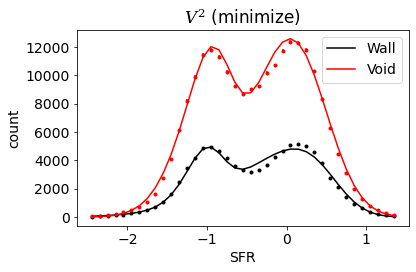

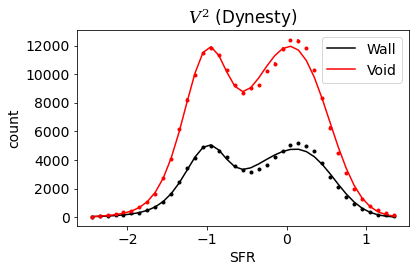

In [75]:
Model_2_plot(V2_SFR_bestfit2.x, 
             SFR[wall_v2], 
             SFR[void_v2], 
             SFR_bins, 
             2, 
             xlabel_text='SFR', 
             title_text='$V^2$ (minimize)')

Model_2_plot(V2_SFR_bestfit2_dynesty, 
             SFR[wall_v2], 
             SFR[void_v2], 
             SFR_bins, 
             2, 
             xlabel_text='SFR', 
             title_text='$V^2$ (Dynesty)')

##### VoidFinder

In [77]:
def prior_xform2_bi_VF(u):
    '''
    Priors for the 16 parameters of bimodal M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(1000, 10000, u[0])
    mu_a1 = uniform(-2, -0.5, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(-5, 0, u[3])

    b1 = jeffreys(1000, 20000, u[4])
    mu_b1 = uniform(-0.5, 1, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 0, u[7])
    
    a2 = jeffreys(100, 8000, u[8])
    mu_a2 = uniform(-2, -0.5, u[9])
    sigma_a2 = uniform(0.01, 2, u[10])
    skew_a2 = uniform(-5, 5, u[11])

    b2 = jeffreys(500, 8000, u[12])
    mu_b2 = uniform(-0.5, 1, u[13])
    sigma_b2 = uniform(0.01, 2, u[14])
    skew_b2 = uniform(-5, 5, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [78]:
Model_2_sampler(prior_xform2_bi_VF, 
                SFR[wall_vf], 
                SFR[void_vf], 
                SFR_bins, 
                2, 
                '_SFR_VoidFinder')

running the nested sampler... this might take from minutes to hours...


11878it [03:41, 56.69it/s, batch: 0 | bound: 155 | nc: 25 | ncall: 275872 | eff(%):  4.298 | loglstar:   -inf < -4199.048 <    inf | logz: -4228.575 +/-  0.337 | dlogz: 2087.087 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
12038it [03:45, 59.41it/s, batch: 0 | bound: 158 | nc: 25 | ncall: 281248 | eff(%):  4.273 | loglstar:   -inf < -4035.867 <    inf | logz: -4066.659 +/-  0.348 | dlogz: 1926.498 >  0.010]/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: R

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_SFR_VoidFinder'


In [80]:
temp_infile = open('dynesty_output/sampler_results_model2_SFR_VoidFinder.pickle', 'rb')
dres2_VF_SFR = pickle.load(temp_infile)
temp_infile.close()

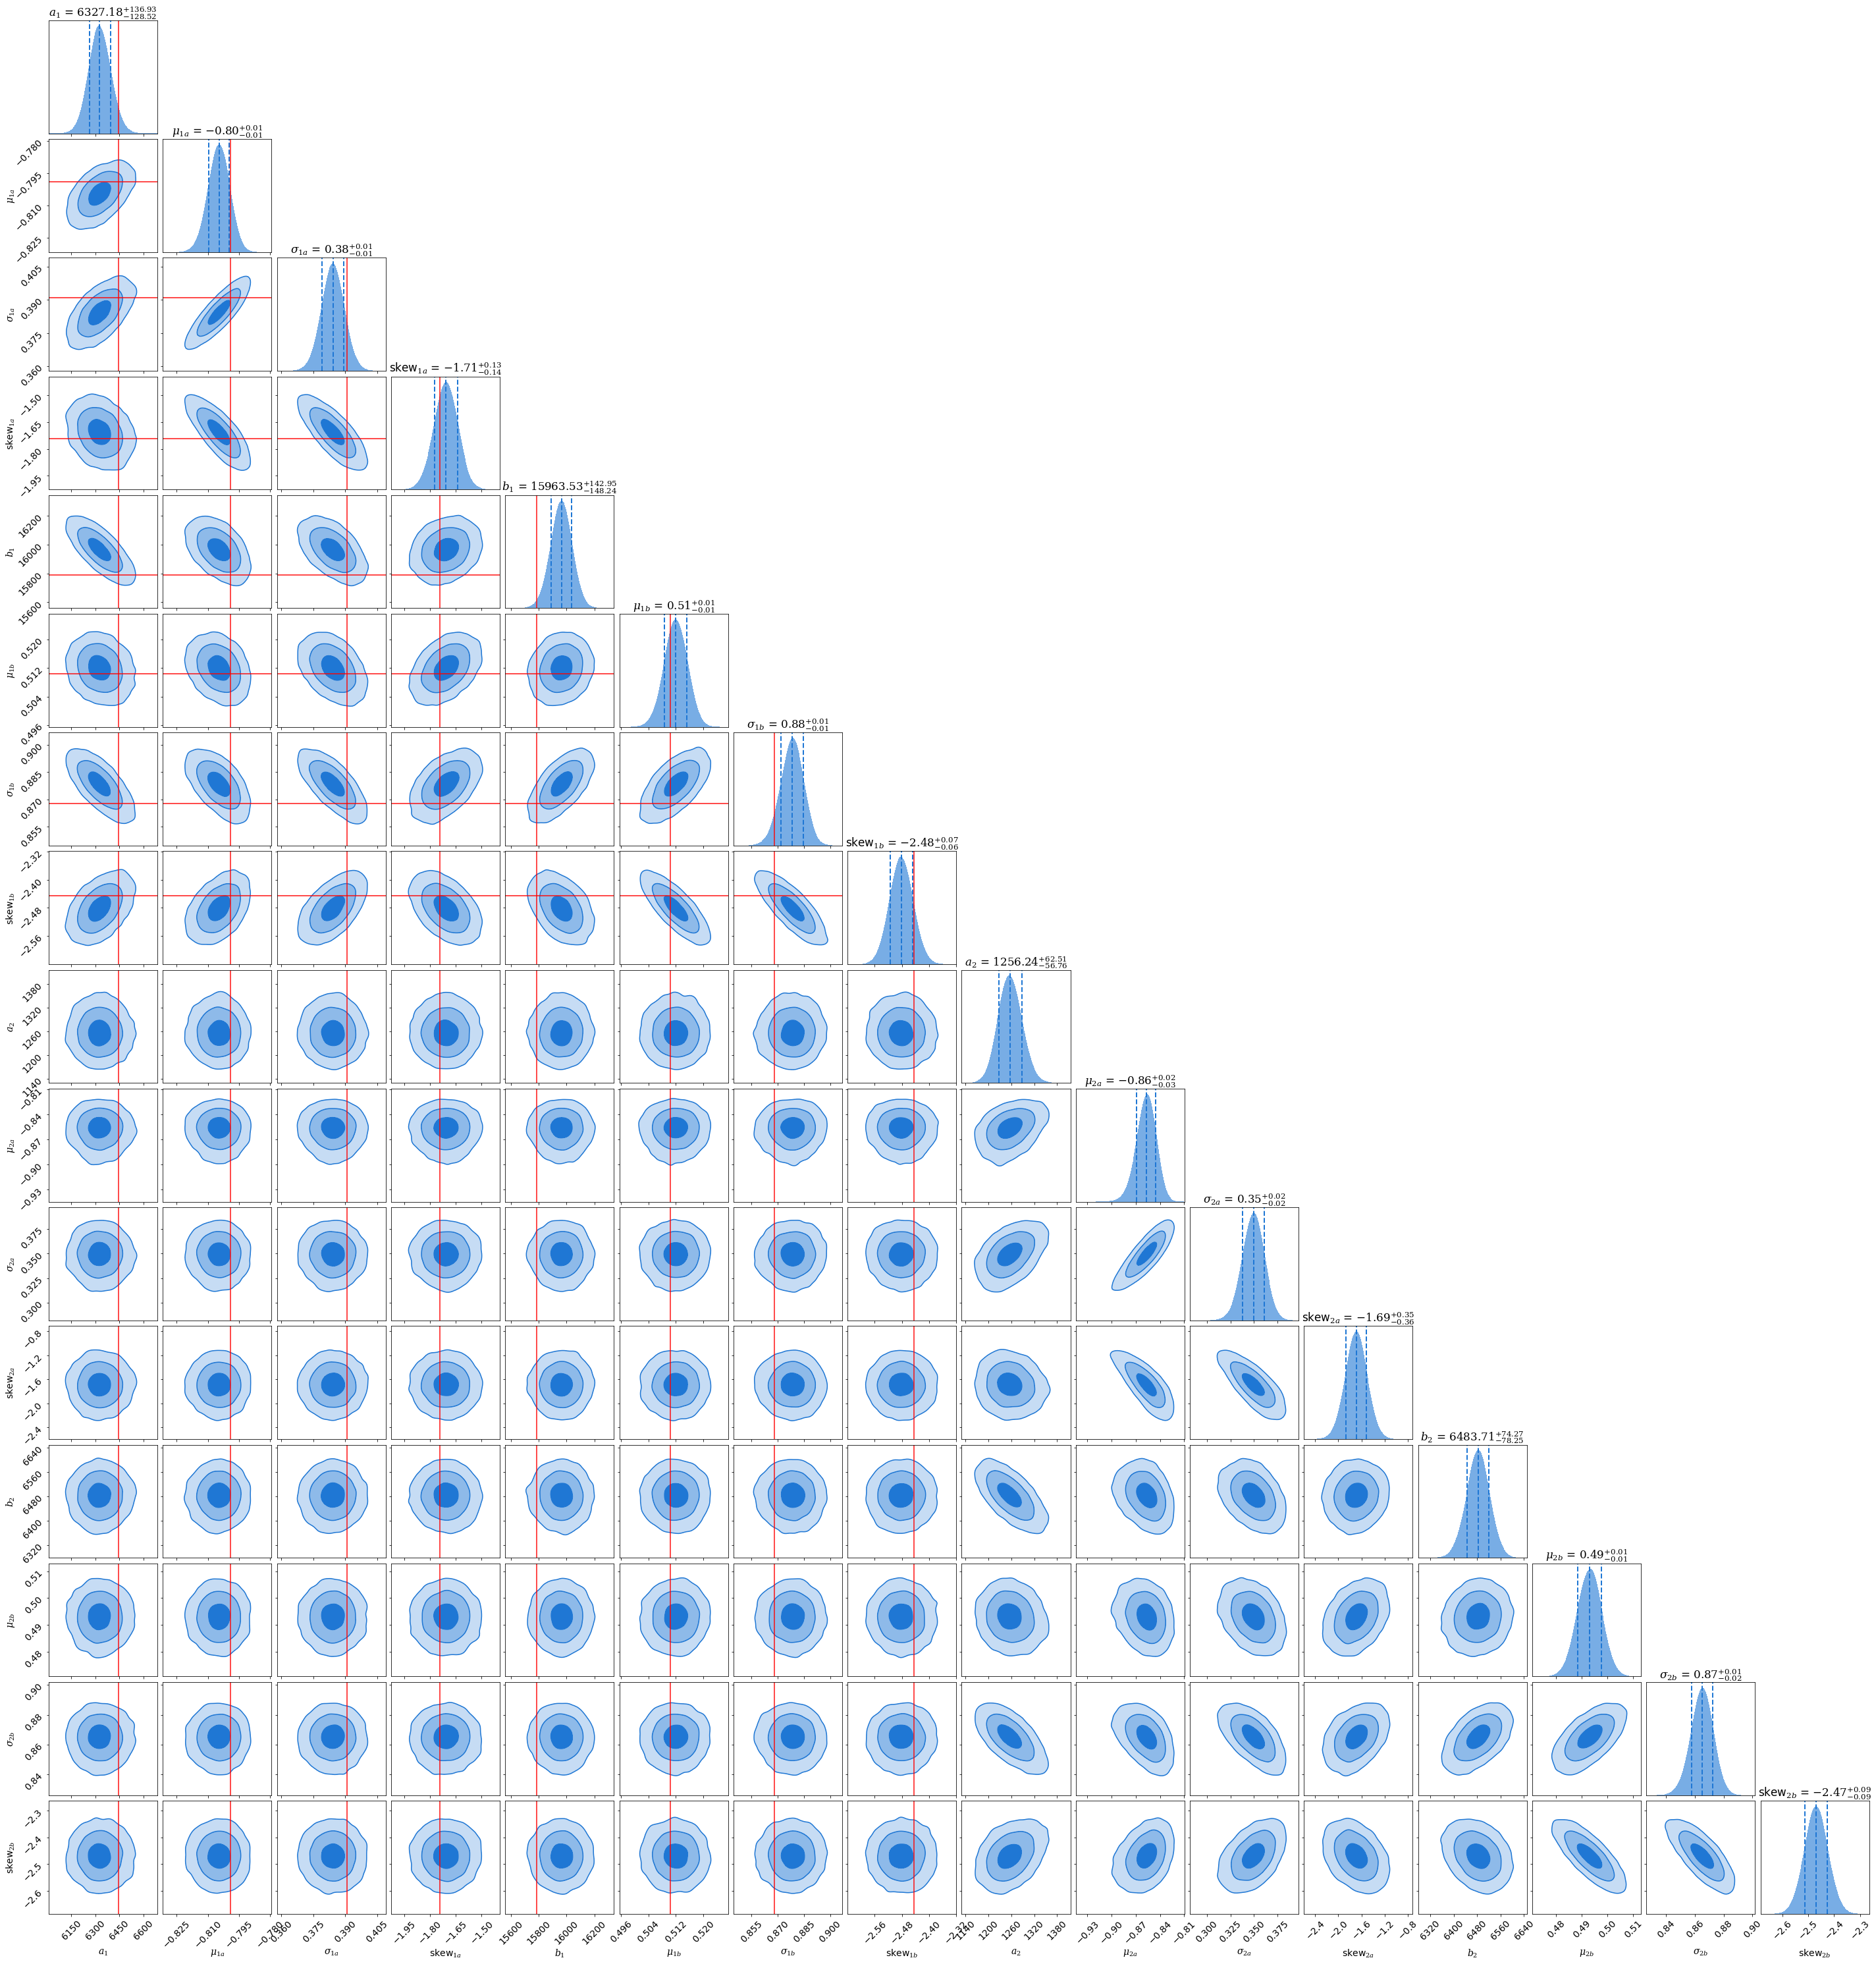

In [81]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_VF_SFR, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=VF_SFR_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

In [82]:
lnzM2_VF_SFR = dres2_VF_SFR.logz[-1]
lnzM2_VF_SFR

-908.4059010493442

In [83]:
VF_SFR_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_VF_SFR.samples, 
                                                np.exp(dres2_VF_SFR.logwt - lnzM2_VF_SFR))

VF_SFR_bestfit2_dynesty

array([ 6.32853432e+03, -8.04636325e-01,  3.84171484e-01, -1.70779927e+00,
        1.59629209e+04,  5.11963897e-01,  8.78207572e-01, -2.48123787e+00,
        1.25696326e+03, -8.57179133e-01,  3.49258424e-01, -1.69060942e+00,
        6.48301439e+03,  4.92983992e-01,  8.64938092e-01, -2.46952088e+00])

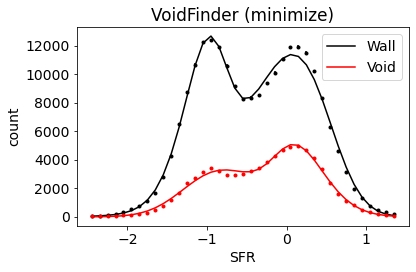

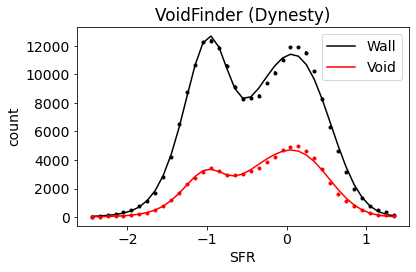

In [84]:
Model_2_plot(VF_SFR_bestfit2.x, 
             SFR[wall_vf], 
             SFR[void_vf], 
             SFR_bins, 
             2, 
             xlabel_text='SFR', 
             title_text='VoidFinder (minimize)')

Model_2_plot(VF_SFR_bestfit2_dynesty, 
             SFR[wall_vf], 
             SFR[void_vf], 
             SFR_bins, 
             2, 
             xlabel_text='SFR', 
             title_text='VoidFinder (Dynesty)')

## Bayes Factor

In [76]:
lnB12_V2_SFR = lnzM1_V2_SFR - lnzM2_V2_SFR

B12_V2_SFR = np.exp(lnB12_V2_SFR)

print('V2 (SFR): B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_SFR, np.log10(B12_V2_SFR)))

V2 (SFR): B12 = 2.34e-66; log(B12) = -65.6


In [85]:
lnB12_VF_SFR = lnzM1_VF_SFR - lnzM2_VF_SFR

B12_VF_SFR = np.exp(lnB12_VF_SFR)

print('VoidFinder (SFR): B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_SFR, lnB12_VF_SFR*np.log10(np.exp(1))))

VoidFinder (SFR): B12 = 0; log(B12) = -436.105


So both VoidFinder and V$^2$ favor $\mathcal{M}_2$, in which the two data sets come from different parent distributions, although VoidFinder favors it much more than V$^2$.